In [1]:
import os
import sys
import pickle
import glob

import mlflow
import torch
import numpy as np
from torchvision.transforms import Compose, Resize, PILToTensor, ConvertImageDtype

ST_DIR = os.getcwd()
EXP_DIR = os.path.dirname(ST_DIR)
ROOT_DIR = os.path.dirname(EXP_DIR)
DATA_DIR = os.path.join(ROOT_DIR, 'data')
sys.path.append(ROOT_DIR)

from core.trainer import BinaryClassifierTrainer
from experiments.st.data_model import STImages
from experiments.st._paths import DataPaths
from experiments.st.datasets import STDataSet

def entropy(array):
    return -1 * (array * np.log2(array)  + (1-array) *np.log2(1-array))


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# model = torch.load(os.path.join(ROOT_DIR, "data", "model.pth"), map_location=torch.device(DEVICE))
model = mlflow.pytorch.load_model("file:///home/oem/repositories/mlflow_artifact/3/cabcd6e6865148f59464bfb408f53b24/artifacts/model")

2024/03/01 00:39:22 WARNING mlflow.pytorch: Stored model version '2.2.0+cu121' does not match installed PyTorch version '2.0.1+cu117'


Entropy: test dataset

In [2]:
path = mlflow.artifacts.download_artifacts(
    "file:///home/oem/repositories/mlflow_artifact/3/cabcd6e6865148f59464bfb408f53b24/artifacts/test_metrics_meter.pkl"
)
with open(path, 'rb') as fh:
    meters = pickle.load(fh)

test_entropy = entropy(np.array(meters.probs))

Entropy: GE

In [3]:
trainer = BinaryClassifierTrainer(model, loss=torch.nn.functional.binary_cross_entropy_with_logits)
data_paths = DataPaths(os.path.join(ROOT_DIR, "data"))
ge_st_images = STImages(
    s_image_paths=glob.glob(str(data_paths.ge.s / "*")),
    t_image_paths=glob.glob(str(data_paths.ge.t / "*")),
)
transform = Compose(
    [PILToTensor(), Resize((512, 512), antialias=True), ConvertImageDtype(torch.float)]
)
data_loader = torch.utils.data.DataLoader(
    STDataSet(
        ge_st_images.image_paths,
        ge_st_images.labels,
        transform,
        device=DEVICE,
    ),
    batch_size=16,
    shuffle=False,
)
ge_loss_meter, ge_metrics_meter = trainer.run_epoch("test", 1, data_loader)
ge_entropy = entropy(np.array(ge_metrics_meter.probs))
print(ge_entropy.mean())

 |################################| test | EPOCH 1: [122/123] | eta:1 | total_loss: 0.10538 | accuracy: 0.95861 | auroc: 0.98029 | prauc: 0.6528 

0.06603495279422453


Entropy: Ruptured

In [4]:
rupture_st_images = STImages(
    s_image_paths=glob.glob(str(data_paths.canon_rupture.s / "*")),
    t_image_paths=glob.glob(str(data_paths.canon_rupture.t / "*")),
)

rupture_data_loader = torch.utils.data.DataLoader(
    STDataSet(
        rupture_st_images.image_paths,
        rupture_st_images.labels,
        transform,
        device=DEVICE,
    ),
    batch_size=1,
    shuffle=False,
)
canon_rupture_loss_meter, canon_rupture_metrics_meter = trainer.run_epoch("test", 1, rupture_data_loader)
canon_rupture_entropy = entropy(np.array(canon_rupture_metrics_meter.probs))
print(canon_rupture_metrics_meter)
print(canon_rupture_entropy.mean())

 |################################| test | EPOCH 1: [130/131] | eta:1 | total_loss: 0.39545 | accuracy: 0.89313 | auroc: 0.99538 | prauc: 0.99864

MetricsMeter(N=(131)), ACC(0.8931297709923665), AUROC(0.9953795379537954), PRAUC(0.9986416944422599)
0.3710931686951735


Entropy: without implant

In [5]:
image_paths = glob.glob(os.path.join(data_paths.data_root_dir, "st_paper_data/no_implants/*.jpg"))
labels = [0 for _ in range(len(image_paths))]
no_implantset = STDataSet(
    image_paths, labels, transform, "cuda"
)
data_loader = torch.utils.data.DataLoader(
    no_implantset,
    batch_size=16,
    shuffle=False,
)
test_loss_meter, no_implant_metrics_meter = trainer.run_epoch("test", 1, data_loader)

 |################################| test | EPOCH 1: [21/22] | eta:1 | total_loss: 1.17228 | accuracy: 0.22781 | auroc: nan | prauc: nan


<Axes: xlabel='entropy', ylabel='Density'>

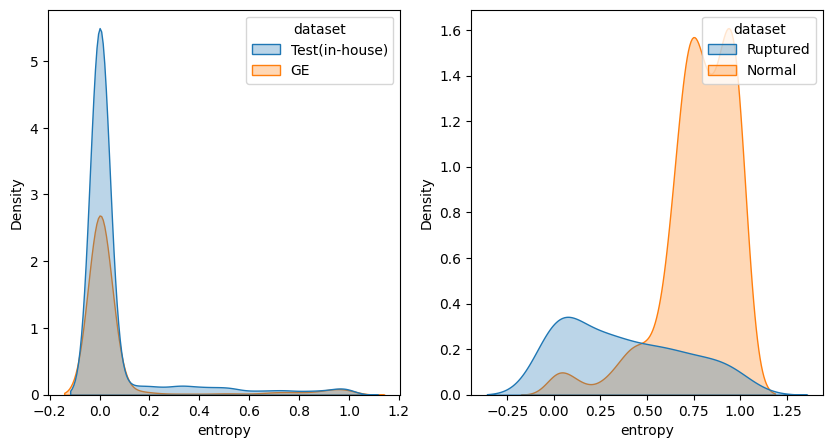

In [12]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

test_entropy_df = pd.DataFrame(test_entropy, columns=["entropy"])
test_entropy_df["dataset"] = "Test(in-house)"
ge_entropy_df = pd.DataFrame(ge_entropy,columns=["entropy"])
ge_entropy_df["dataset"] = "GE"
rupture_entropy_df = pd.DataFrame(canon_rupture_entropy, columns=["entropy"])
rupture_entropy_df["dataset"] = "Ruptured"
normal_entropy = entropy(np.array(no_implant_metrics_meter.probs))
normal_entropy_df = pd.DataFrame(normal_entropy, columns=["entropy"])
normal_entropy_df["dataset"] = "Normal"

df = pd.concat(
    [
        test_entropy_df, 
        ge_entropy_df,
        rupture_entropy_df, 
        normal_entropy_df
    ]
).reset_index(drop=True)
df.to_csv("entropy.csv", index=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(df.loc[df["dataset"].isin({"Test(in-house)", "GE"})], x="entropy", hue="dataset", fill=True, alpha=0.3, multiple="layer", ax=axes[0])
sns.kdeplot(df.loc[df["dataset"].isin({"Ruptured", "Normal"})], x="entropy", hue="dataset", fill=True, alpha=0.3, multiple="layer", ax=axes[1])

In [12]:
# statistis
import pandas as pd
from tableone import TableOne
entropy = pd.read_csv("entropy.csv")
TableOne(entropy.loc[entropy["dataset"].isin({"Test(in-house)", "GE"})], missing=False, pval=True, groupby="dataset", overall=False, decimals=3)

Grouped by dataset                       
                                    GE Test(in-house) P-Value
n                                 1957           3480        
entropy, mean (SD)       0.066 (0.216)  0.072 (0.201)   0.350

In [13]:
TableOne(entropy.loc[entropy["dataset"].isin({"Test(in-house)", "Ruptured"})], missing=False, pval=True, groupby="dataset", overall=False, decimals=3)

Grouped by dataset                       
                              Ruptured Test(in-house) P-Value
n                                  131           3480        
entropy, mean (SD)       0.371 (0.318)  0.072 (0.201)  <0.001

In [14]:
TableOne(entropy.loc[entropy["dataset"].isin({"Ruptured", "Normal"})], missing=False, pval=True, groupby="dataset", overall=False, decimals=3) 

Grouped by dataset                       
                                Normal       Ruptured P-Value
n                                  338            131        
entropy, mean (SD)       0.777 (0.199)  0.371 (0.318)  <0.001